In [1]:
from datetime import datetime
start_real = datetime.now() # 全体の処理時間の計測を開始する

#### ライブラリのインポート

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.sparse import load_npz

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
import lightgbm as lgb

import warnings
warnings.simplefilter("ignore")

#### X と y の読み込み

In [3]:
# Kaggle Notebook
X = load_npz('/kaggle/input/mercari-preprocessed/X.npz')
y = pd.read_csv('/kaggle/input/mercari-preprocessed/y.csv')

#### モデルの作成と学習

#### X と y のうち、7割を訓練用 (train)、3割を検証用 (test) に分割する

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [5]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1032740, 186740)
(1032740, 1)
(442604, 186740)
(442604, 1)


#### モデルの学習｜LightGBM

In [6]:
# データセットの形式を変更
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [7]:
# ハイパーパラメータの設定
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 15,
    'learning_rate': 1.0,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.6,
    'bagging_freq': 5,
    'verbose': 10,
    'num_boost_round': 100,
    'early_stopping_rounds': 10,
    'seed': 0
}

In [8]:
%%time
gbm = lgb.train(params, train_data, valid_sets=valid_data)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.999570
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.999505
[LightGBM] [Debug] init for col-wise cost 664.380731 seconds, init for row-wise cost 665.750746 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 666.276041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1067750
[LightGBM] [Info] Number of data points in the train set: 1032740, number of used features: 65802
[LightGBM] [Debug] Use subset for bagging
[LightGBM] [Info] Start training from score 2.981379
[LightGBM] [Debug] Re-bagging, using 619579 data to train
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
Training until validation scores don't improve for 10 rounds
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 12
[LightGBM] [Debug] Trained a 

#### 訓練データに対する予測｜LightGBM

In [9]:
y_train_pred = gbm.predict(X_train)

In [10]:
# 元のスケールに戻す
y_train_cp = y_train.copy()
y_train_pred_cp = y_train_pred.copy()

y_train_cp = np.expm1(y_train_cp)
y_train_pred_cp = np.expm1(y_train_pred_cp)

In [11]:
y_min = np.append(y_train_pred_cp, y_train_cp).min()
y_max = np.append(y_train_pred_cp, y_train_cp).max()
y_margin = (y_max - y_min) * 0.1
y_min -= y_margin
y_max += y_margin

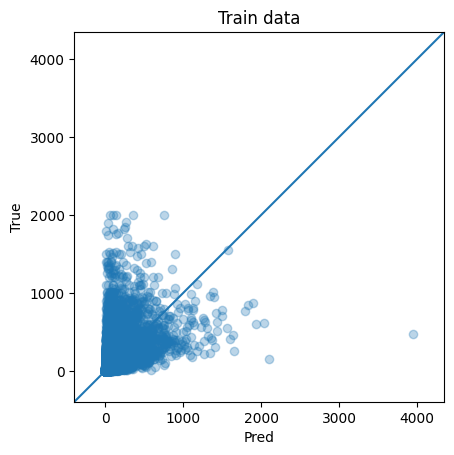

In [12]:
plt.scatter(y_train_pred_cp, y_train_cp, alpha=0.3)
plt.plot([y_min,y_max], [y_min,y_max])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(y_min, y_max)
plt.ylim(y_min, y_max)
plt.title('Train data')
plt.xlabel('Pred')
plt.ylabel('True')
plt.show()

In [13]:
# RMSLE関数の定義
def rmsle(y_true, y_pred):  
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [14]:
# モデルの評価
gbm_train_rmsle = rmsle(np.expm1(y_train), np.expm1(y_train_pred))
print("RMSLE for train data:", gbm_train_rmsle)

RMSLE for train data: 0.49973873241558214


#### テストデータに対する予測｜LightGBM

In [15]:
y_test_pred = gbm.predict(X_test)

In [16]:
# 元のスケールに戻す
y_test_cp = y_test.copy()
y_test_pred_cp = y_test_pred.copy()

y_test_cp = np.expm1(y_test_cp)
y_test_pred_cp = np.expm1(y_test_pred_cp)

In [17]:
y_min = np.append(y_test_pred_cp, y_test_cp).min()
y_max = np.append(y_test_pred_cp, y_test_cp).max()
y_margin = (y_max - y_min) * 0.1
y_min -= y_margin
y_max += y_margin

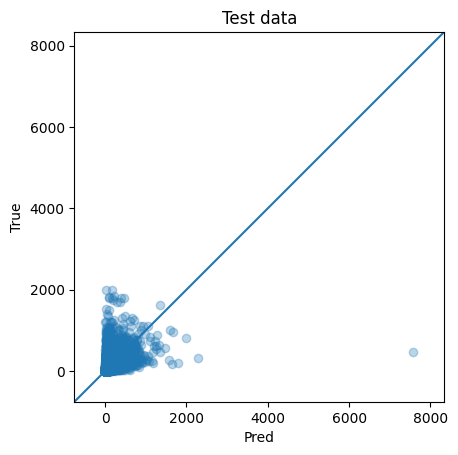

In [18]:
plt.scatter(y_test_pred_cp, y_test_cp, alpha=0.3)
plt.plot([y_min,y_max], [y_min,y_max])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(y_min, y_max)
plt.ylim(y_min, y_max)
plt.title('Test data')
plt.xlabel('Pred')
plt.ylabel('True')
plt.show()

In [19]:
# モデルの評価
gbm_test_rmsle = rmsle(np.expm1(y_test), np.expm1(y_test_pred))
print("RMSLE for test data:", gbm_test_rmsle)

RMSLE for test data: 0.5036272774221142


In [20]:
stop_real = datetime.now()
execution_time_real = stop_real - start_real
print(execution_time_real)

0:36:30.533037
